In [1]:
import numpy as np
import pandas as pd
%matplotlib inline 
import matplotlib.pyplot as plt


from sklearn.model_selection import train_test_split

import tensorflow as tf

# tensorflow libaries
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Dropout, Conv2D, BatchNormalization,MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.callbacks import Callback, EarlyStopping, ModelCheckpoint
from tensorflow.keras import optimizers

from tensorflow.keras import Model
from tensorflow.keras.applications import MobileNetV2, VGG19
from tensorflow.keras.layers.experimental import preprocessing


In [ ]:
def load_data(root = 'aml-2024-feather-in-focus/'):

    # load labels and corresponding bird species names
    data = np.load(root + 'class_names.npy', allow_pickle=True)
    data = dict(data.item())    
    class_names = pd.DataFrame(data.items(), columns=['name', 'label'])

    # remove first 4 characters for every class and  replace underscores with spaces
    class_names['name'] = class_names['name'].apply(lambda x: x[4:]).apply(lambda x: x.replace('_', ' '))

    # load the paths of the bird images test set
    birds_df = pd.read_csv(root + 'train_images.csv')
    birds_df['image_path'] = birds_df['image_path'].apply(lambda x: root + 'train_images' + x)   

    # merge the labels and image paths with the species names
    birds_df = birds_df.merge(class_names, left_on='label', right_on='label')

    return birds_df, class_names

birds_df, class_names = load_data()
birds_df.head()


                         name  label
0  001.Black_footed_Albatross      1
1        002.Laysan_Albatross      2
2         003.Sooty_Albatross      3
3       004.Groove_billed_Ani      4
4          005.Crested_Auklet      5
aml-2024-feather-in-focus/train_images/train_images/2.jpg
Black footed Albatross


In [3]:
train_df, test_df = train_test_split(birds_df, test_size=0.2,
                                     shuffle=True,random_state=42, stratify=birds_df['name'])
train_gen = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input,
    validation_split=0.2
)

test_gen = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input,
)

# Split the data into three categories
train_images = train_gen.flow_from_dataframe(
    dataframe=train_df,
    x_col='image_path',
    y_col='name',
    target_size=(224,224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='training'
)

val_images = train_gen.flow_from_dataframe(
    dataframe=train_df,
    x_col='image_path',
    y_col='name',
    target_size=(224,224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='validation'
)

test_images = test_gen.flow_from_dataframe(
    dataframe=test_df,
    x_col='image_path',
    y_col='name',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)

Found 2512 validated image filenames belonging to 200 classes.
Found 628 validated image filenames belonging to 200 classes.
Found 786 validated image filenames belonging to 200 classes.


In [4]:
# Resize Layer
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(224,224),
    layers.experimental.preprocessing.Rescaling(1./255),
])

In [5]:
base_model = MobileNetV2(
    input_shape=(224,224,3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)

base_model.trainable=False

In [6]:
inputs = base_model.input
x = resize_and_rescale(inputs)
x = Dense(256, activation='relu')(base_model.output)
x = Dropout(0.2)(x)
x = Dense(256,activation='relu')(x)
x = Dropout(0.2)(x)

outputs = Dense(200,activation='softmax')(x)

model =  Model(inputs=inputs, outputs=outputs)

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                                             

In [7]:
config={            "learning_rate":0.0001,
                    "epochs":100,
                    "batch_size":32,
                    "es_patience":8,
                    "loss_function":"categorical_crossentropy",
                    
                }
## Optimizer
optimizer = tf.keras.optimizers.Adam(config["learning_rate"])

## Early Stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=config["es_patience"],
                              restore_best_weights=True)
# Create checkpoint callback
checkpoint_path = "birds_classification_model_checkpoint"
checkpoint_callback = ModelCheckpoint(checkpoint_path,
                                      save_weights_only=True,
                                      monitor="val_accuracy",
                                      save_best_only=True)

# Model compile
model.compile(optimizer,config["loss_function"],metrics=['accuracy'])
model.compile

<bound method Model.compile of <keras.engine.functional.Functional object at 0x0000018C2144E0A0>>

In [8]:
history = model.fit(
    train_images, 
    steps_per_epoch=len(train_images),
    validation_data=val_images,
    validation_steps=len(val_images),
    epochs=config["epochs"],
    callbacks=[
        early_stopping,
        checkpoint_callback,
    ]
)

Epoch 1/100
79/79 [==============================] - 66s 790ms/step - loss: 5.3092 - accuracy: 0.0115 - val_loss: 5.1991 - val_accuracy: 0.0207
Epoch 2/100
79/79 [==============================] - 46s 586ms/step - loss: 5.0794 - accuracy: 0.0434 - val_loss: 5.0168 - val_accuracy: 0.0685
Epoch 3/100
79/79 [==============================] - 35s 443ms/step - loss: 4.8239 - accuracy: 0.0665 - val_loss: 4.7639 - val_accuracy: 0.0971
Epoch 4/100
79/79 [==============================] - 35s 444ms/step - loss: 4.5050 - accuracy: 0.1087 - val_loss: 4.4485 - val_accuracy: 0.1449
Epoch 5/100
79/79 [==============================] - 35s 439ms/step - loss: 4.1383 - accuracy: 0.1501 - val_loss: 4.1239 - val_accuracy: 0.1752
Epoch 6/100
79/79 [==============================] - 35s 440ms/step - loss: 3.8086 - accuracy: 0.2058 - val_loss: 3.8369 - val_accuracy: 0.1990
Epoch 7/100
79/79 [==============================] - 37s 469ms/step - loss: 3.4794 - accuracy: 0.2480 - val_loss: 3.5754 - val_accuracy:

In [12]:
results = model.evaluate(test_images)

print("    Test Loss: {:.5f}%".format(results[0]))
print("Test Accuracy: {:.2f}%".format(results[1]*100))

25/25 [==============================] - 11s 437ms/step - loss: 1.8196 - accuracy: 0.5229
    Test Loss: 1.81960%
Test Accuracy: 52.29%


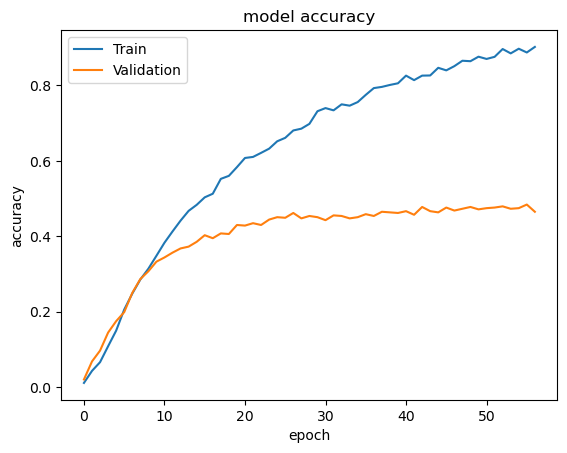

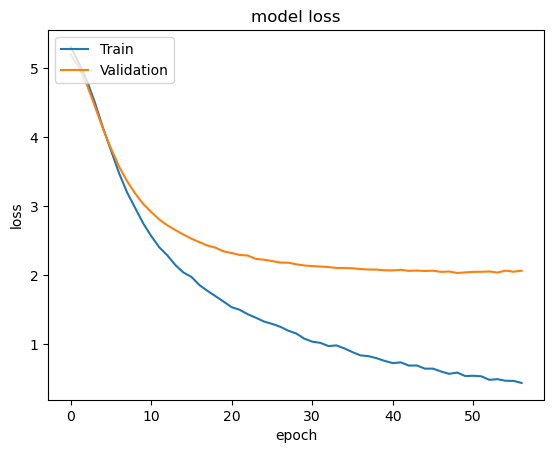

In [10]:
def plot_loss_accuracy_curves(history):
    # summarize history for accuracy
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show();
    
plot_loss_accuracy_curves(history)

In [ ]:
# save the model

model.save('MobileNetV2_100epochs_model.h5')
model.save_weights('MobileNetV2_100epochs_weights.h5')

# # load the model

model2 = tf.keras.models.load_model('birds_classification_model.h5')
model2.load_weights('birds_classification_model_weights.h5')

# results = model2.evaluate(test_images)

# print("    Test Loss: {:.5f}%".format(results[0]))
# print("Test Accuracy: {:.2f}%".format(results[1]*100))